<a href="https://colab.research.google.com/github/mj-woo/Deep-Learning/blob/main/09_Assigment_6_text_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copyright

<PRE>
Copyright (c) Bálint Gyires-Tóth - All Rights Reserved
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.
</PRE>

# Assignment: RNN text generation with your favorite book


## 1. Dataset
- Download your favorite book from https://www.gutenberg.org/
- Split into training (80%) and validation (20%).

In [13]:
import requests
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
import matplotlib.pyplot as plt
import math

# Download the text (example: "Pride and Prejudice" by Jane Austen)
url = "https://www.gutenberg.org/files/1342/1342-0.txt"
text = requests.get(url).text
text = text[:200000]

print("Original length:", len(text))

# Split into train (80%) and validation (20%)
split_index = int(len(text) * 0.8)
train_text = text[:split_index]
val_text = text[split_index:]
print("training length:", len(train_text))
print("validation length:", len(val_text))

Original length: 200000
training length: 160000
validation length: 40000


## 2. Preprocessing
- Convert text to lowercase.  
- Remove punctuation (except basic sentence delimiters).  
- Tokenize by words or characters (your choice).  
- Build a vocabulary (map each unique word to an integer ID).

In [14]:
# Convert to lowercase
text = text.lower()

# Keep only basic sentence delimiters and words
text = re.sub(r'[^a-zA-Z0-9\s\.\!\?]', '', text)

# Split into words (word-level tokenization)
words = text.split()
print(f"Total tokens: {len(words)}")

# Get unique words
vocab = sorted(set(words))

# Create mappings
word2idx = {word: idx for idx, word in enumerate(vocab)}
idx2word = {idx: word for word, idx in word2idx.items()}

# Convert all words in text to integers using word2idx
encoded_text = [word2idx[word] for word in words]

print(f"Vocabulary size: {len(vocab)}")

Total tokens: 33399
Vocabulary size: 4947


## 3. Embedding Layer in Keras
Below is a minimal example of defining an `Embedding` layer:
```python
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    input_dim=vocab_size,     # size of the vocabulary
    output_dim=128,           # embedding vector dimension
    input_length=sequence_length
)
```
- This layer transforms integer-encoded sequences (word IDs) into dense vector embeddings.

- Feed these embeddings into your LSTM or GRU OR 1D CNN layer.

In [15]:
# Parameters
sequence_length = 20  # Number of input words to predict the next word

def create_sequences(encoded_text, seq_length):
    sequences = []
    for i in range(seq_length, len(encoded_text)):
        seq = encoded_text[i - seq_length:i + 1]  # 20 input + 1 output
        sequences.append(seq)
    return sequences

# Create sequences and shuffle
sequences = create_sequences(encoded_text, sequence_length)
sequences = np.array(sequences)
print("Total sequences:", len(sequences))

# Split into input (X) and target (y)
X, y = sequences[:, :-1], sequences[:, -1]

# One-hot encode target
y = to_categorical(y, num_classes=len(vocab))

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Total sequences: 33379


## 4. Model
- Implement an LSTM or GRU or 1D CNN-based language model with:
  - **The Embedding layer** as input.
  - At least **one recurrent layer** (e.g., `LSTM(256)` or `GRU(256)` or your custom 1D CNN).
  - A **Dense** output layer with **softmax** activation for word prediction.
- Train for about **5–10 epochs** so it can finish in approximately **2 hours** on a standard machine.


In [23]:
from tensorflow.keras.layers import Dropout

# Define the model
model = Sequential([
    Embedding(input_dim=len(vocab), output_dim=128, input_length=sequence_length),
    LSTM(256, return_sequences=False),
    Dropout(0.3),
    Dense(len(vocab), activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

## 5. Training & Evaluation
- **Monitor** the loss on both training and validation sets.
- **Perplexity**: a common metric for language models.
  - It is the exponent of the average negative log-likelihood.
  - If your model outputs cross-entropy loss `H`, then `perplexity = e^H`.
  - Try to keep the validation perplexity **under 50** if possible. If you have higher value (which is possible) try to draw conclusions, why doesn't it decrease to a lower value.

Epoch 1/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 93s 111ms/step - accuracy: 0.0638 - loss: 6.1722 - val_accuracy: 0.0762 - val_loss: 6.3337
Epoch 2/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 138s 106ms/step - accuracy: 0.0815 - loss: 5.9052 - val_accuracy: 0.0998 - val_loss: 6.2273
Epoch 3/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 142s 107ms/step - accuracy: 0.1110 - loss: 5.5224 - val_accuracy: 0.1092 - val_loss: 6.1999
Epoch 4/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 92s 111ms/step - accuracy: 0.1250 - loss: 5.2238 - val_accuracy: 0.1135 - val_loss: 6.2613
Epoch 5/5
835/835 ━━━━━━━━━━━━━━━━━━━━ 138s 106ms/step - accuracy: 0.1457 - loss: 4.9096 - val_accuracy: 0.1077 - val_loss: 6.3845


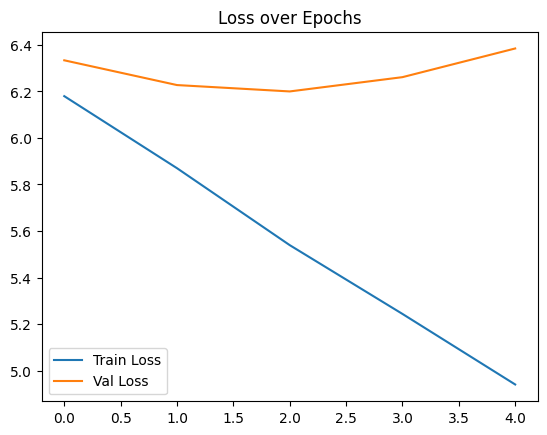

Validation Perplexity: 592.61


In [26]:
# Train the model
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32,
    callbacks=[early_stop]
)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()

# Calculate perplexity
final_val_loss = history.history['val_loss'][-1]
perplexity = math.exp(final_val_loss)
print(f"Validation Perplexity: {perplexity:.2f}")


I get a validation perplexity of over 50 due to the following reasons:
- limited training epochs; the model may be overfitting
- dataset characteristics: Pride and Prejudice is a complex literary text with long, intricate sentence structures with archaic grammar & vocabulary and high variation in word usage and style. This increases uncertainty of word prediction tasks.

## 6. Generation Criteria
- After training, generate **two distinct text samples**, each at least **50 tokens**.
- Use **different seed phrases** (e.g., “love is” vs. “time will”).

In [27]:
def generate_text(seed_text, num_words=50):
    result = seed_text.lower().split()

    for _ in range(num_words):
        # Convert seed text to IDs
        encoded = [word2idx.get(w, 0) for w in result[-sequence_length:]]
        padded = pad_sequences([encoded], maxlen=sequence_length, truncating='pre')

        # Predict next word
        pred_probs = model.predict(padded, verbose=0)[0]
        next_word_id = np.argmax(pred_probs)
        next_word = idx2word[next_word_id]

        result.append(next_word)

    return ' '.join(result)

# Generate samples
sample1 = generate_text("love is")
sample2 = generate_text("time will")

print("\nSample 1:\n", sample1)
print("\nSample 2:\n", sample2)


Sample 1:
 love is a very deal and i am sure to be a very deal and i am sure to be a very deal and i am sure to be a very deal and i am sure to be a very deal and i am sure to be a very deal and i

Sample 2:
 time will be a very deal and i am sure to be a very deal and i am sure to be a very deal and i am sure to be a very deal and i am sure to be a very deal and i am sure to be a very deal and
